양방향 LSTM과 어텐션 메커니즘으로 IMDB 리뷰 감성 분류하기를 수행해보자.

## 1. IMDB 리뷰 데이터 전처리하기

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
print('리뷰의 최대 길이 : {}'.format(max(len(l) for l in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


In [4]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 2. 바다나우 어텐션(Bahdanau Attention)

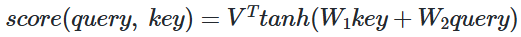

In [6]:
import tensorflow as tf

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units): # units : hidden unit 크기
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units) # 인코더 출력값(Values, Key)들을 가중치를 곱하여 변환하는 Dense 레이어
    self.W2 = Dense(units) # 디코더의 이전 타임스텝 은닉 상태(Query)에 가중치를 곱하는 Dense 레이어
    self.V = Dense(1) # score 계산

	# values : 인코더의 출력값(Key와 Value 역할)
	# query: 디코더의 현재 은닉 상태
  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    # softmax를 적용하여 어텐션 가중치를 계산

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## 3. 양방향 LSTM + 어텐션 메커니즘

In [7]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [8]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
# 첫번째 층
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

In [10]:
# 두번째 층
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

In [11]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 500, 128) (None, 64) (None, 64) (None, 64) (None, 64)


In [12]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

In [15]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [16]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train, epochs = 3, batch_size = 256, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 1002s 10s/step - accuracy: 0.6276 - loss: 0.6158 - val_accuracy: 0.8604 - val_loss: 0.3376
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 1027s 10s/step - accuracy: 0.8996 - loss: 0.2814 - val_accuracy: 0.8688 - val_loss: 0.3131
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 946s 10s/step - accuracy: 0.9287 - loss: 0.2103 - val_accuracy: 0.8830 - val_loss: 0.2801


In [19]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 260s 332ms/step - accuracy: 0.8846 - loss: 0.2798

 테스트 정확도: 0.8830
